<a href="https://colab.research.google.com/github/muhammadalfateh6/Skin-lesion-Classification-Deep-learning/blob/main/ResNet50_PH2_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.0.1+cu118


# Preparing Training and Test Sets

In [3]:
class_names = ['Head', 'Helmet', 'Person']
root_dir = '/content/drive/MyDrive/Data_150'
source_dirs = ['/content/drive/MyDrive/Data_150/Head', '/content/drive/MyDrive/Data_150/Helmet', '/content/drive/MyDrive/Data_150/Person']

# if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
#     os.mkdir(os.path.join(root_dir, 'test'))

#     for i, d in enumerate(source_dirs):
#         os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

#     for c in class_names:
#         os.mkdir(os.path.join(root_dir, 'test', c))

#     for c in class_names:
#         images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('bmp')]
#         selected_images = random.sample(images, 30)
#         for image in selected_images:
#             source_path = os.path.join(root_dir, c, image)
#             target_path = os.path.join(root_dir, 'test', c, image)
#             shutil.move(source_path, target_path)

# Creating Custom Dataset

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Head', 'Helmet', 'Person']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [5]:
train_trans= torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

test_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [8]:
train_dirs = {
    'Head': '/content/drive/MyDrive/Data_150/Head',
    'Helmet': '/content/drive/MyDrive/Data_150/Helmet',
    'Person': '/content/drive/MyDrive/Data_150/Person'
}
train_dataset= ChestXRayDataset(train_dirs, train_trans)

Found 41 Head examples
Found 64 Helmet examples
Found 56 Person examples


In [6]:
test_dirs = {
    'Head': '/content/drive/MyDrive/Data Helmet Detection/Head',
    'Helmet': '/content/drive/MyDrive/Data Helmet Detection/Helmet',
    'Person': '/content/drive/MyDrive/Data Helmet Detection/Person'
    }
test_dataset= ChestXRayDataset(test_dirs, test_trans)

Found 10 Head examples
Found 10 Helmet examples
Found 11 Person examples


In [10]:
batch_size =5

dl_train = torch.utils.data.DataLoader(train_dataset, 
                                       batch_size=batch_size,
                                      shuffle=True)
dl_test =torch.utils.data.DataLoader(test_dataset,
                                      batch_size = batch_size,
                                     shuffle=True)
print('Number of Training batches', len(dl_train))
print('Number of test bactches', len(dl_test))

Number of Training batches 33
Number of test bactches 7


# Data Visualization

In [11]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

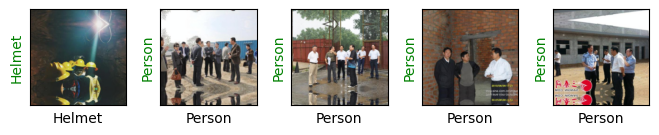

In [12]:
images, labels= next(iter(dl_train))
show_images(images, labels, labels)

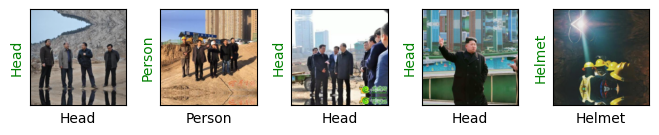

In [13]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [14]:
model = torchvision.models.resnet18(pretrained =True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 258MB/s]


In [15]:
model.fc =torch.nn.Linear(in_features =512, out_features=3)
loss_fn =torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [16]:
def show_preds():
    model.eval()
    images, labels =next(iter(dl_test))
    outputs =model(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

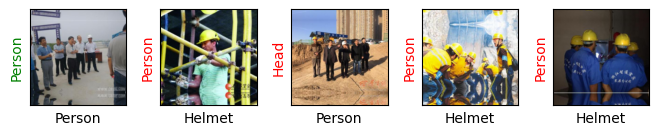

In [17]:
show_preds()

# Training the Model

In [19]:
def train(epochs):
    print('Starting training')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        model.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                model.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                model.train()

                #if accuracy >= 0.95:
                 #   print('Performance condition satisfied. now i can rest for good..')
                  #  return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training completed..')

Starting training
Starting epoch 1/25
Evaluating at step 0
Validation Loss: 1.3328, Accuracy: 0.6452


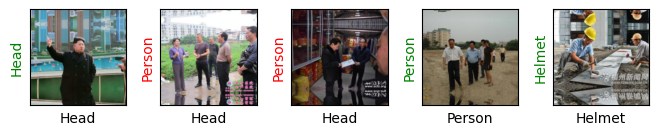

Evaluating at step 20
Validation Loss: 1.7809, Accuracy: 0.7419


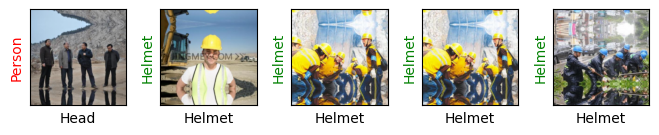

Training Loss: 0.0670
Starting epoch 2/25
Evaluating at step 0
Validation Loss: 0.9953, Accuracy: 0.7419


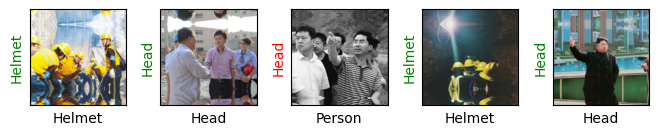

Evaluating at step 20
Validation Loss: 2.0522, Accuracy: 0.6452


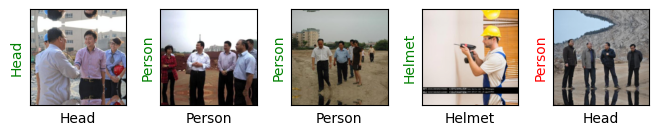

Training Loss: 0.1270
Starting epoch 3/25
Evaluating at step 0
Validation Loss: 1.7329, Accuracy: 0.7097


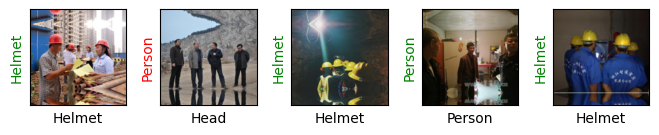

Evaluating at step 20
Validation Loss: 2.4455, Accuracy: 0.5806


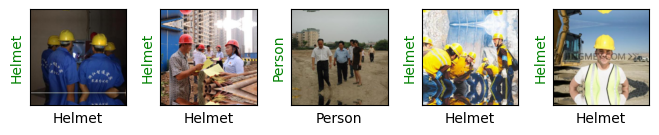

Training Loss: 0.0602
Starting epoch 4/25
Evaluating at step 0
Validation Loss: 1.8612, Accuracy: 0.7097


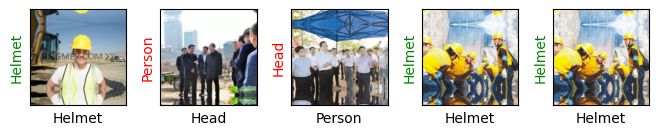

Evaluating at step 20
Validation Loss: 3.2204, Accuracy: 0.4194


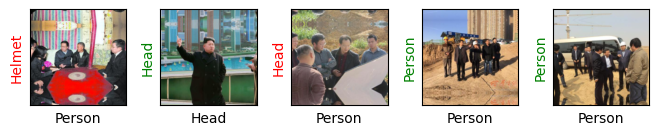

Training Loss: 0.0650
Starting epoch 5/25
Evaluating at step 0
Validation Loss: 3.3546, Accuracy: 0.6774


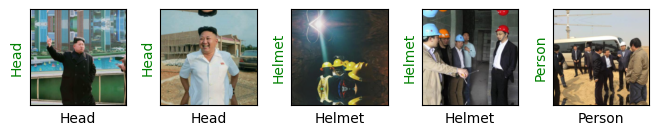

Evaluating at step 20
Validation Loss: 1.6324, Accuracy: 0.7742


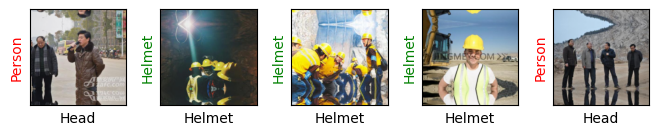

Training Loss: 0.0748
Starting epoch 6/25
Evaluating at step 0
Validation Loss: 1.0260, Accuracy: 0.6774


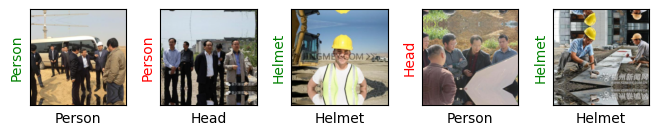

Evaluating at step 20
Validation Loss: 1.7094, Accuracy: 0.7097


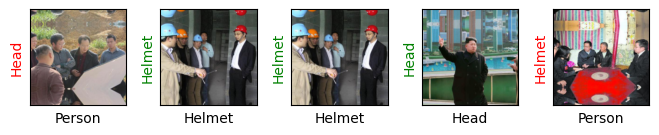

Training Loss: 0.0912
Starting epoch 7/25
Evaluating at step 0
Validation Loss: 1.6701, Accuracy: 0.6774


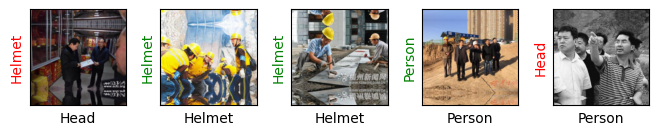

Evaluating at step 20
Validation Loss: 2.4188, Accuracy: 0.6129


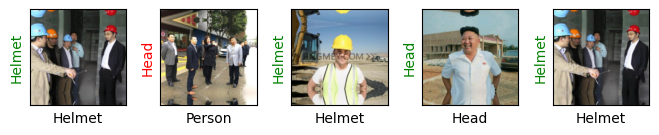

Training Loss: 0.1505
Starting epoch 8/25
Evaluating at step 0
Validation Loss: 1.5498, Accuracy: 0.7097


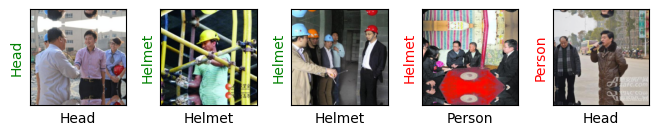

Evaluating at step 20
Validation Loss: 2.5129, Accuracy: 0.6129


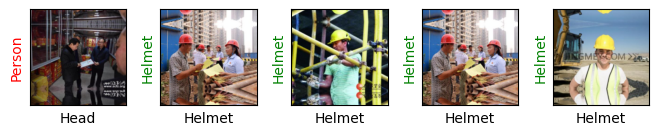

Training Loss: 0.1555
Starting epoch 9/25
Evaluating at step 0
Validation Loss: 2.1123, Accuracy: 0.5161


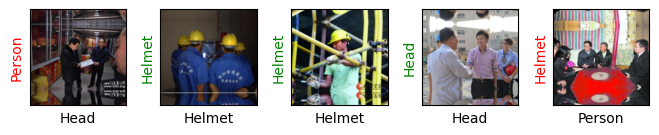

Evaluating at step 20
Validation Loss: 4.5574, Accuracy: 0.4839


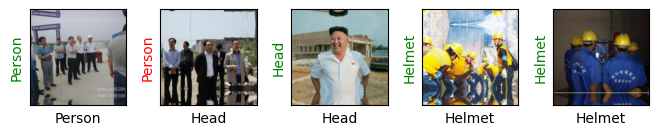

Training Loss: 0.1021
Starting epoch 10/25
Evaluating at step 0
Validation Loss: 1.6883, Accuracy: 0.6452


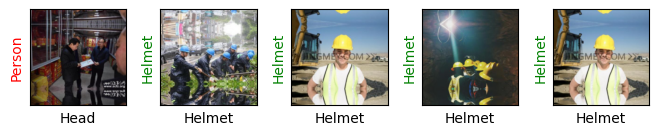

Evaluating at step 20
Validation Loss: 3.1334, Accuracy: 0.6129


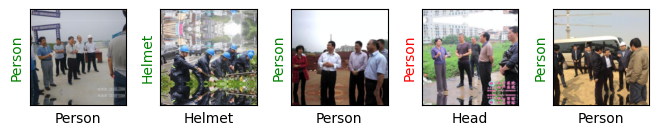

Training Loss: 0.1711
Starting epoch 11/25
Evaluating at step 0
Validation Loss: 1.6380, Accuracy: 0.7097


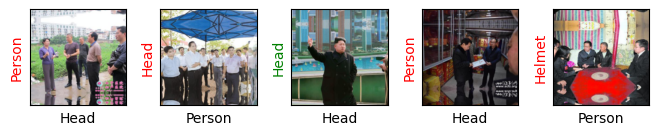

Evaluating at step 20
Validation Loss: 1.3291, Accuracy: 0.7097


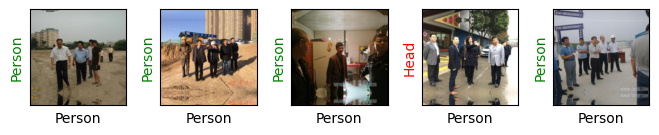

Training Loss: 0.1246
Starting epoch 12/25
Evaluating at step 0
Validation Loss: 2.4882, Accuracy: 0.7097


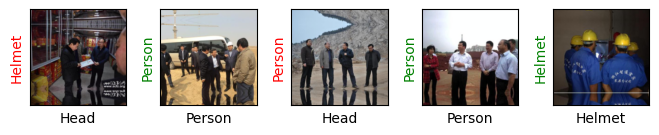

Evaluating at step 20
Validation Loss: 2.2750, Accuracy: 0.5806


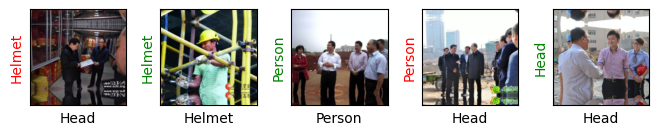

Training Loss: 0.0810
Starting epoch 13/25
Evaluating at step 0
Validation Loss: 1.6351, Accuracy: 0.7097


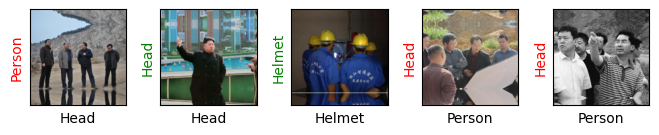

Evaluating at step 20
Validation Loss: 1.7311, Accuracy: 0.8065


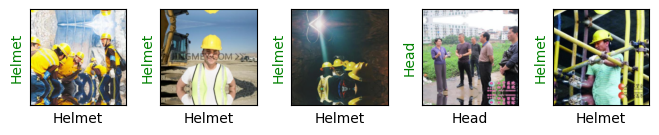

Training Loss: 0.1344
Starting epoch 14/25
Evaluating at step 0
Validation Loss: 3.5554, Accuracy: 0.6129


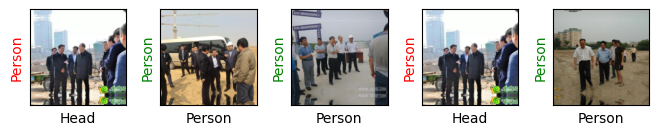

Evaluating at step 20
Validation Loss: 3.0723, Accuracy: 0.5161


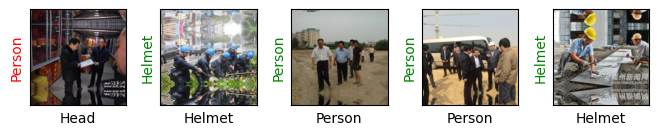

Training Loss: 0.0776
Starting epoch 15/25
Evaluating at step 0
Validation Loss: 2.7183, Accuracy: 0.5484


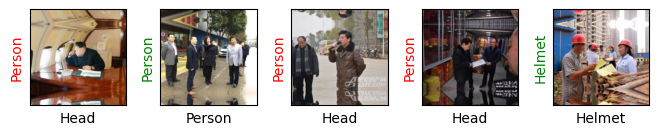

Evaluating at step 20
Validation Loss: 2.0585, Accuracy: 0.6452


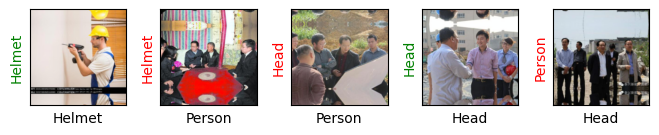

Training Loss: 0.0691
Starting epoch 16/25
Evaluating at step 0
Validation Loss: 2.5698, Accuracy: 0.6452


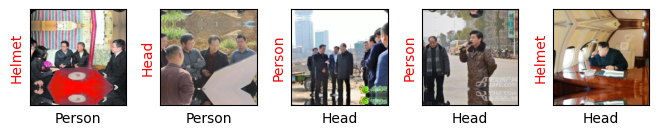

Evaluating at step 20
Validation Loss: 1.7287, Accuracy: 0.7419


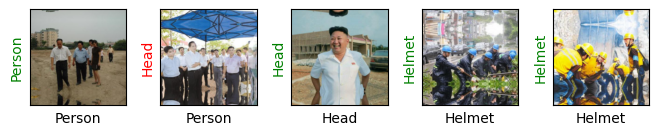

Training Loss: 0.0578
Starting epoch 17/25
Evaluating at step 0
Validation Loss: 2.3441, Accuracy: 0.6129


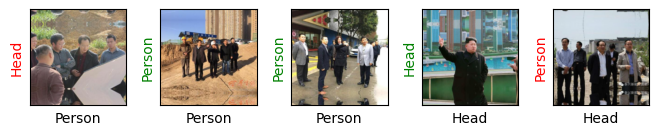

Evaluating at step 20
Validation Loss: 2.2521, Accuracy: 0.7419


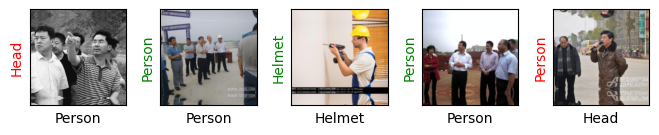

Training Loss: 0.1008
Starting epoch 18/25
Evaluating at step 0
Validation Loss: 1.4243, Accuracy: 0.7742


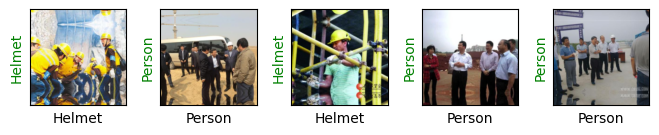

Evaluating at step 20
Validation Loss: 1.8870, Accuracy: 0.7097


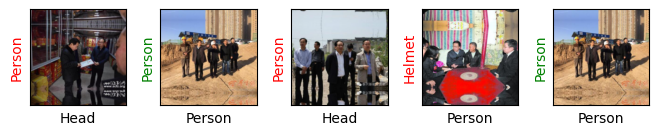

Training Loss: 0.0816
Starting epoch 19/25
Evaluating at step 0
Validation Loss: 1.9196, Accuracy: 0.6129


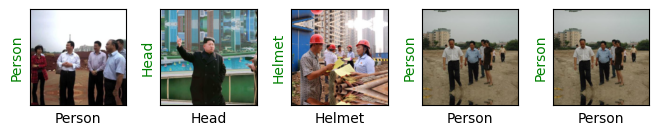

Evaluating at step 20
Validation Loss: 3.9994, Accuracy: 0.4839


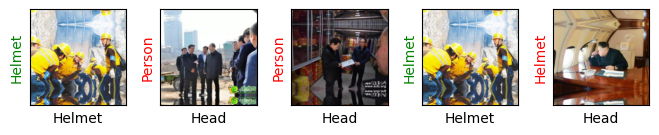

Training Loss: 0.1509
Starting epoch 20/25
Evaluating at step 0
Validation Loss: 2.1185, Accuracy: 0.6452


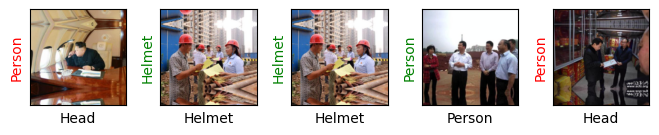

Evaluating at step 20
Validation Loss: 2.1694, Accuracy: 0.5806


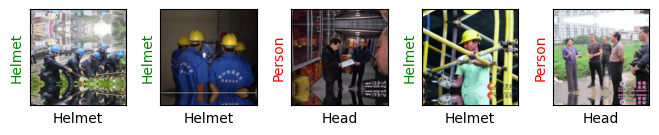

Training Loss: 0.0564
Starting epoch 21/25
Evaluating at step 0
Validation Loss: 1.1788, Accuracy: 0.7742


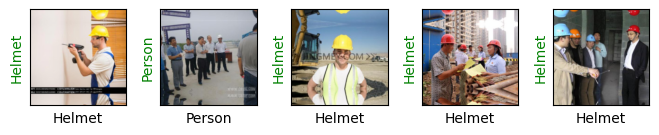

Evaluating at step 20
Validation Loss: 1.9082, Accuracy: 0.6774


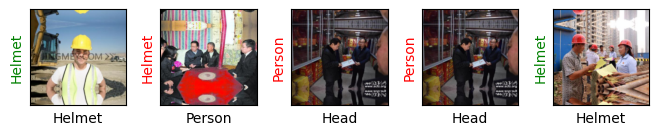

Training Loss: 0.0575
Starting epoch 22/25
Evaluating at step 0
Validation Loss: 2.1614, Accuracy: 0.5484


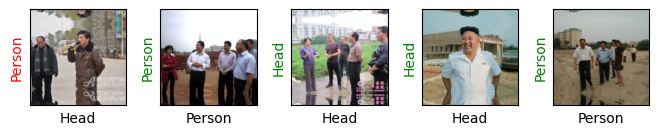

Evaluating at step 20
Validation Loss: 2.5038, Accuracy: 0.6452


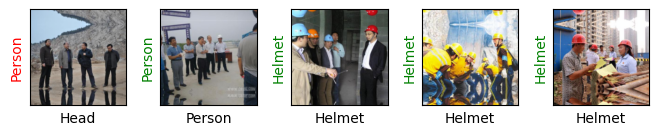

Training Loss: 0.0583
Starting epoch 23/25
Evaluating at step 0
Validation Loss: 2.1441, Accuracy: 0.5484


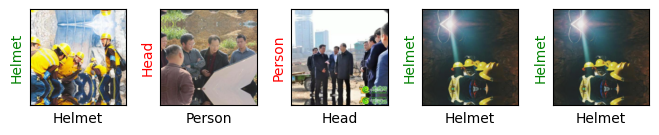

Evaluating at step 20
Validation Loss: 3.4630, Accuracy: 0.3871


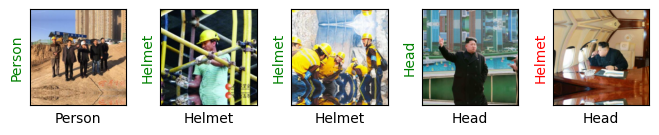

Training Loss: 0.1402
Starting epoch 24/25
Evaluating at step 0
Validation Loss: 2.3837, Accuracy: 0.6129


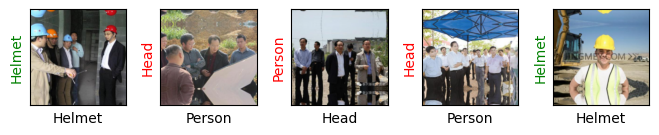

Evaluating at step 20
Validation Loss: 2.8336, Accuracy: 0.6129


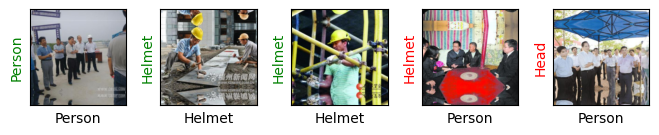

Training Loss: 0.0846
Starting epoch 25/25
Evaluating at step 0
Validation Loss: 1.0989, Accuracy: 0.7742


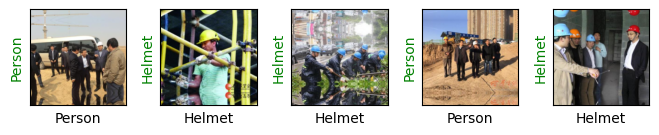

Evaluating at step 20
Validation Loss: 2.3987, Accuracy: 0.6774


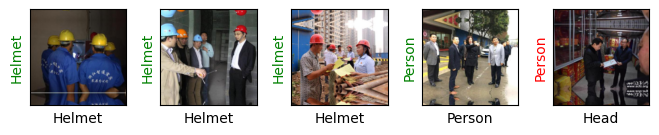

Training Loss: 0.0616
Training completed..


In [24]:
train(epochs=25)

# Final Results

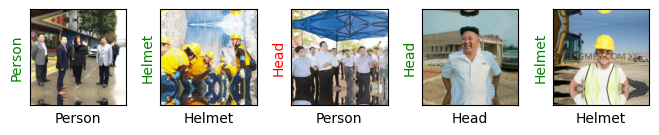

In [32]:
show_preds()